<!--HEADER-->
[*Notas sobre modelagem da epidemia de Covid-19*](https://github.com/rmsrosa/modcovid19) / [*IM-UFRJ*](https://www.im.ufrj.br).

<!--BADGES-->
<a href="../slides/04.00.Aula-Compartimentais_estruturados.slides.html"><img align="left" src="https://img.shields.io/badge/local-slides-darkgreen" alt="localslides" title="Local Slides"></a>
&nbsp;

<!--NAVIGATOR-->
[<- Modelos epidemiológicos compartimentais](03.00.Aula-Modelos_compartimentais.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) | [Qualidade e comparação de modelos ->](05.00.Aula-Qualidade_e_comparacao_de_modelos.ipynb)

---


# Modelos compartimentais estruturados

Desta vez, vamos ver:

- Modelos compartimentais onde os diferentes estágios da doença estão divididos em determinadas estruturas, ou grupos.

- Especificamente, um modelo SIS com duas estruturas.

- Análise matemática do modelo SIS com duas estruturas.

## Importando as bibliotecas e preparação inicial

In [1]:
import datetime as dt # date and time tools

import numpy as np # linear algebra

from scipy.integrate import solve_ivp # ode solver

import networkx as nx # graph tool

from IPython.display import Image # display images

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
dt_string = dt.datetime.now().strftime("%d/%b/%Y")
print(f"Atualização mais recente do kernel: {dt_string}")

Atualização mais recente do kernel: 06/May/2020


## Modelos estruturados

Modelos estruturados aparecem naturalmente quando há uma separação entre grupos de indivíduos dentro de um mesmo estágio de uma doença.

Essas estruturas podem aparecer por diversos motivos:

- Motivos geográficos, e.g. grupos separados por bairros, cidades ou países.

- Motivos comportamentais, e.g. grupos de alto risco vs grupos de baixo risco.


### Exemplos 

#### HIV em Colorado Springs

Rede de relações de contato sexual analisada em um estudo de transmissão de HIV em Colorado Springs, EUA (Fonte: Keeling & Rohani (2007)):

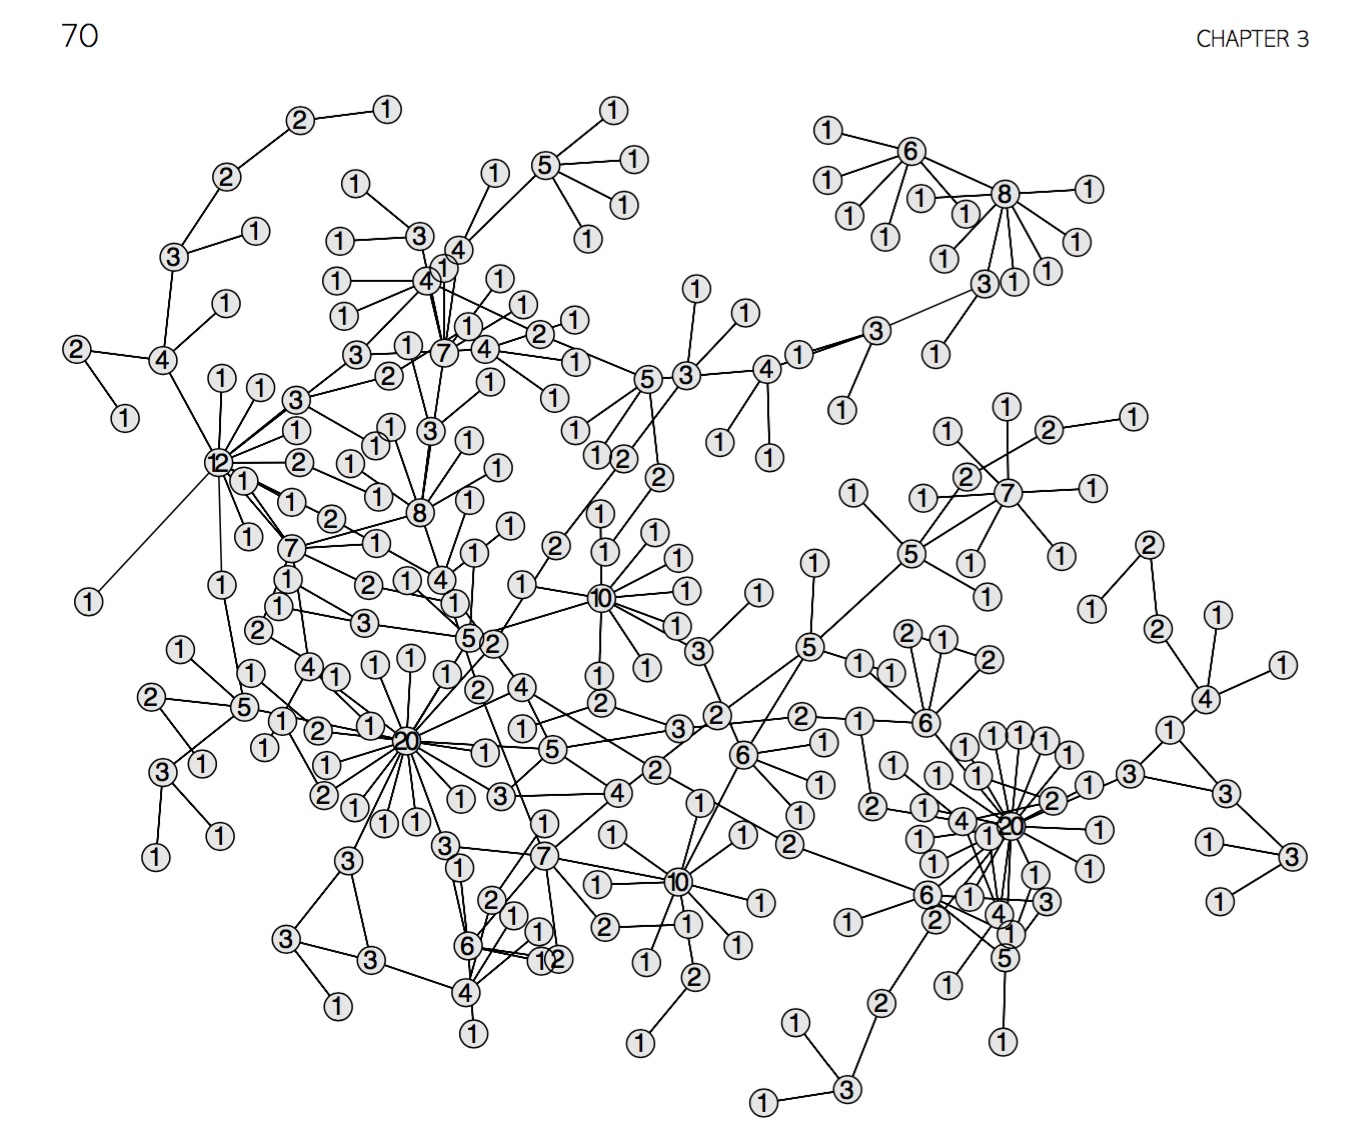

In [3]:
Image("../input/compartimentos_estruturados/HIV_ColoradoSprings_network.jpg", width=800)

#### Divisão em bairros

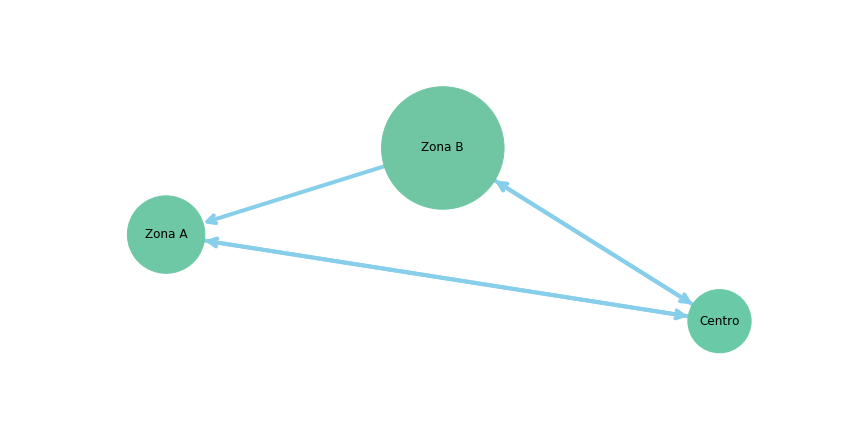

In [4]:
Image("../input/compartimentos_estruturados/rede_sitios.png", width=800)

## Modelo SIS homogêneo

Lembremos do modelo SIS homogêneo, onde a população está dividida entre indivíduos **suscetíveis** e indivíduos **infectados-contagiosos** e estes são tratados de maneira homogênea. As respectivas populações são denotadas por $S$ e $I$, com o total permanecendo constante

$$ S + I = N
$$

Neste caso, temos dois parâmetros:

- $\beta:$ **taxa de transmissão**

- $\gamma:$ **taxa de recuperação**

Este modelo é utilizado, por exemplo, para 

- a gripe comum; e

- algumas doenças sexualmente transmissíveis (DST) causadas por bactérias, como *gonorréia*, *sífilis*, *clamídia* e *candidíase*.

### Modelo na forma de ação de massas

$$
\begin{cases}
  S + I \stackrel{\beta}{\rightarrow} 2I, & \text{(processo de infeção)} \\
  I \stackrel{\gamma}{\rightarrow} S, & \text{(processo de recuperação)}.
\end{cases}
$$

### Modelo na forma de grafo

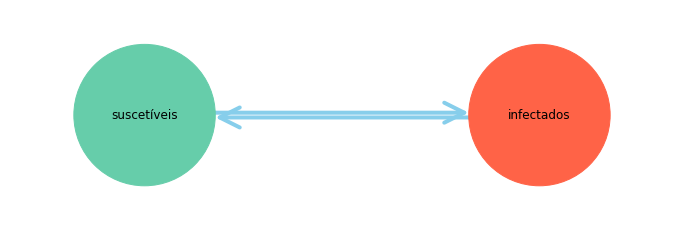

In [5]:
# build digraph

mdg_sis = nx.MultiDiGraph()
mdg_sis.add_node(1, compartimento='suscetíveis', node_color='mediumaquamarine')
mdg_sis.add_node(2, compartimento='infectados', node_color='tomato')
mdg_sis.add_edges_from([(1,2, {'taxa': r'\beta\,i'}), (2,1, {'taxa': r'\gamma'})])

# prepare for visualization
pos = {j: (j,0) for j in iter(mdg_sis.nodes)}
pos_for_right_edges = {j: (j, 0.01) for j in iter(mdg_sis.nodes)}
pos_for_left_edges = {j: (j, -0.01) for j in iter(mdg_sis.nodes)}

labels = {j: mdg_sis.nodes[j]['compartimento'] for j in iter(mdg_sis.nodes)}
edge_labels = {j: mdg_sis.edges[j]['taxa'] for j in iter(mdg_sis.edges)}
color_map = [mdg_sis.nodes[j]['node_color'] for j in iter(mdg_sis.nodes)]

# display graph
plt.figure(figsize=(12,4))

nx.draw_networkx_nodes(mdg_sis, pos, node_size=20000, with_labels=True, node_shape='o', node_color=color_map)
nx.draw_networkx_labels(mdg_sis, pos, labels=labels, fontsize=24)
#nx.draw_networkx_edges(mdg_sis, pos, node_size=20000, with_labels=True, arrowstyle='->', arrowsize=50, 
#                       edge_color='skyblue', width=4)
#nx.draw_networkx_edge_labels(mdg_sis, pos_for_right_edges, edge_labels, font_size=16)

nx.draw_networkx_edges(mdg_sis, pos_for_right_edges, edgelist=[(1,2)], node_size=20000, with_labels=True, arrowstyle='->', arrowsize=50, 
                       edge_color='skyblue', width=4)
nx.draw_networkx_edges(mdg_sis, pos_for_left_edges, edgelist=[(2,1)], node_size=20000, with_labels=True, arrowstyle='->', arrowsize=50, 
                       edge_color='skyblue', width=4)

#nx.draw_networkx_edge_labels(mdg_sis, {1:pos_for_right_edges[1]}, {(1,2,0):edge_labels[(1,2,0)]}, font_size=16)
plt.axis('off')
plt.margins(0.2)
plt.show()

## Modelo SIS com duas estruturas

Vamos considerar, agora, um modelo SIS com duas estruturas, dividindo a população em dois grupos, os de alto-risco e os de baixo-risco.

A análise abaixo é baseado na Seção 3.1.1 de Keeling & Rohani (2007).

Definimos as seguintes variáveis:

- $S_H = $ população de indivíduos suscetíveis de alto risco *(H=How)*.

- $I_H = $ população de indivíduos infectados de alto risco *(H=How)*.

- $S_L = $ população de indivíduos suscetíveis de baixo risco *(L=Low)*.

- $I_L = $ população de indivíduos infectados de baixo risco *(L=Low)*.

As populações totais de cada grupo permanecem constantes, assim como a população total:

$$ S_H + I_H = N_H \textrm{ (constante)}, \qquad S_L + I_L = N_L \textrm{ (constante)}, \qquad N_H + N_L = N \textrm{ (constante)}.
$$

### Dinâmica

- Assumimos que o comportamento de cada indivíduo não muda, portanto, se ele é de baixo risco, continua sendo de baixo risco, mesmo que infectado, e se ele é de alto risco, idem.

- A recuperação também se dá dentro do mesmo grupo, com um infectado de baixo risco eventualmente sendo curado e se tornando suscetível de baixo risco e, da mesma forma, um indivíduo infectado de alto risco se tornando suscetível de alto risco.

- No entanto, um indivíduo suscetível de baixo ou de alto risco pode se tornar infectado se relacionando com um indivíduo infectado de qualquer um dos dois grupos.

Na forma de ação de massas, isso pode ser descrito pelas reações

$$
\begin{cases}
  S_H + I_H \stackrel{\beta_{HH}}{\rightarrow} 2I_H, & \text{(processo de infeção entre indivíduos de alto risco)} \\
  S_H + I_L \stackrel{\beta_{HL}}{\rightarrow} I_H + I_L, & \text{(processo de infeção entre um suscetível de alto risco e um infectado de baixo risco)} \\
  S_L + I_H \stackrel{\beta_{LH}}{\rightarrow} I_L + I_H, & \text{(processo de infeção entre um suscetível de baixo risco e um infectado de alto risco)} \\
  S_L + I_L \stackrel{\beta_{LL}}{\rightarrow} 2I_L, & \text{(processo de infeção entre indivíduos de baixo risco)} \\
  I_H \stackrel{\gamma_H}{\rightarrow} S_H, & \text{(processo de recuperação de indivíuos de alto risco)} \\
  I_L \stackrel{\gamma_L}{\rightarrow} S_L, & \text{(processo de recuperação de indivíuos de baixo risco)}.
\end{cases}
$$

### Parâmetros

Os parâmetros são similares ao do SIS homogêneo, mas levando em consideração as peculiaridades de cada grupo. Mais precisamente:

- $\beta_{HH} =$ taxa de transmissão por unidade de tempo por indivíduo suscetível de baixo risco a partir de interações com o indivíduos infectados de alto risco ("high to high").

- $\beta_{HL} =$ taxa de transmissão por unidade de tempo por indivíduo suscetível de baixo risco a partir de interações com o indivíduos infectados de baixo risco ("low to high").

- $\beta_{LH} =$ taxa de transmissão por unidade de tempo por indivíduo suscetível de baixo risco a partir de interações com o indivíduos infectados de alto risco ("high to low").

- $\beta_{LL} =$ taxa de transmissão por unidade de tempo por indivíduo suscetível de baixo risco a partir de interações com indivíduos infectados de baixo risco ("low to low").

- $\gamma_H =$ taxa de recuperação por unidade de tempo por indivíduo infectado de alto risco.

- $\gamma_L =$ taxa de recuperação por unidade de tempo por indivíduo infectado de baixo risco.

### Relações típicas entre os parâmetros

É comum considerar as seguintes simplificações nos parâmetros:

- $\beta_{HH} \gg \beta_{LL}$: a taxa de transmissão é maior entre indivíduos de alto risco do que entre os de baixo risco, pois o número de encontros por indivíduo por unidade de tempo entre os indivíduos de maior risco é maior do que entre os de menor risco;

- $\beta_{LL} \gg \beta_{LH}, \,\beta_{HL}$, com base em que o número de encontros entre indivíuos de grupos diferentes é menor do que entre indivíduos do mesmo grupo.

- $\beta_{HL} = \beta_{LH}$: as taxas de transmissões são simétricas entre os diferentes grupos; 

- $\gamma_L = \gamma_H$: as taxas de recuperação independem do grupo de risco;

### Representação na forma de grafo

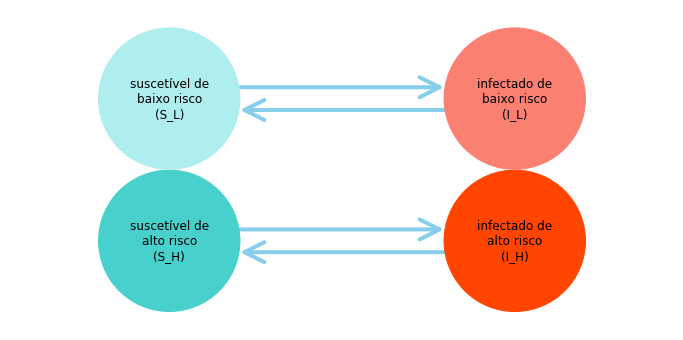

In [6]:
# build digraph
# see https://i.stack.imgur.com/lFZum.png for named colors
mdg_sis_sd = nx.MultiDiGraph()

mdg_sis_sd.add_node(1, compartimento='suscetível de\nalto risco\n(S_H)', node_color='mediumturquoise')
mdg_sis_sd.add_node(2, compartimento='infectado de\nalto risco\n(I_H)', node_color='orangered')
mdg_sis_sd.add_node(3, compartimento='suscetível de\nbaixo risco\n(S_L)', node_color='paleturquoise')
mdg_sis_sd.add_node(4, compartimento='infectado de\nbaixo risco\n(I_L)', node_color='salmon')

mdg_sis_sd.add_edges_from([(1,2, {'taxa': r'\beta_{LL}\,i_L\,s_L + \beta{LH}\,i_H \,s_L'}), (2,1, {'taxa': r'\gamma\,i'})])
mdg_sis_sd.add_edges_from([(3,4, {'taxa': r'\beta\,i\,s'}), (4,3, {'taxa': r'\gamma\,i'})])

# prepare for visualization
pos_nodes = {j: ((j+1) % 2 +1, (j+1) // 2 - 1) for j in iter(mdg_sis_sd.nodes)}
#pos_edges = {j: ((j+1) % 2 +1, (j+1) // 2 - 1) for j in iter(mdg_sis_sd.nodes)}
pos_for_right_edges = {j: ((j+1) % 2 +1, (j+1) // 2 - 1 + 0.08) for j in iter(mdg_sis_sd.nodes)}
pos_for_left_edges = {j: ((j+1) % 2 +1, (j+1) // 2 - 1 - 0.08) for j in iter(mdg_sis_sd.nodes)}

labels = {j: mdg_sis_sd.nodes[j]['compartimento'] for j in iter(mdg_sis_sd.nodes)}
edge_labels = {j: mdg_sis_sd.edges[j]['taxa'] for j in iter(mdg_sis_sd.edges)}
color_map = [mdg_sis_sd.nodes[j]['node_color'] for j in iter(mdg_sis_sd.nodes)]

# display graph
plt.figure(figsize=(12,6))

nx.draw_networkx_nodes(mdg_sis_sd, pos_nodes, node_size=20000, with_labels=True, node_shape='o', node_color=color_map)
nx.draw_networkx_labels(mdg_sis_sd, pos_nodes, labels=labels, fontsize=24)
#nx.draw_networkx_edges(mdg_sis_sd, pos, node_size=20000, with_labels=True, arrowstyle='->', arrowsize=50, 
#                       edge_color='skyblue', width=4)
#nx.draw_networkx_edge_labels(mdg_sis_sd, pos_for_right_edges, edge_labels, font_size=16)

nx.draw_networkx_edges(mdg_sis_sd, pos_for_right_edges, edgelist=[(1,2), (3,4)], node_size=20000, with_labels=True, arrowstyle='->', arrowsize=50, 
                       edge_color='skyblue', width=4)
nx.draw_networkx_edges(mdg_sis_sd, pos_for_left_edges, edgelist=[(2,1), (4,3)], node_size=20000, with_labels=True, arrowstyle='->', arrowsize=50, 
                       edge_color='skyblue', width=4)


#nx.draw_networkx_edge_labels(mdg_sis_sd, {1:pos_for_right_edges[1]}, {(1,2,0):edge_labels[(1,2,0)]}, font_size=16)
plt.axis('off')
plt.margins(0.3)
plt.show()

### Representação incluindo ações/processos

In [7]:
mdg_sis_sd.add_node(5, compartimento='', node_color='white')
mdg_sis_sd.add_node(6, compartimento='', node_color='white')

mdg_sis_sd.add_edges_from([(2,5, {'taxa': r'\beta_{LL}\,i_L\,s_L + \beta{LH}\,i_H \,s_L'}), (2,6, {'taxa': r'\gamma\,i'})])
mdg_sis_sd.add_edges_from([(4,5, {'taxa': r'\beta\,i\,s'}), (4,6, {'taxa': r'\gamma\,i'})])

pos_for_cross_transmission = {2: (2, 0.08), 4: (2, 1.08), 5: (1.5, 0.08), 6: (1.5, 1.08)}

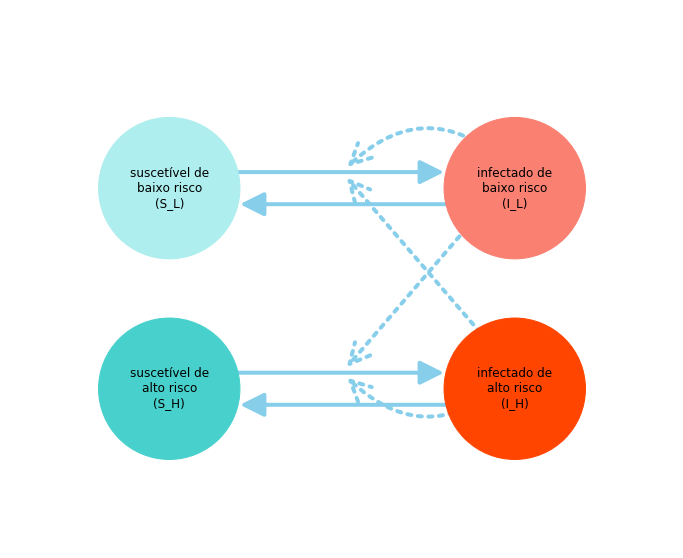

In [8]:
# display graph
plt.figure(figsize=(12,10))

nx.draw_networkx_nodes(mdg_sis_sd, pos_nodes, nodelist = [1,2,3,4], node_size=20000, with_labels=True, node_shape='o', node_color=color_map)
nx.draw_networkx_labels(mdg_sis_sd, pos_nodes, nodelist = [1,2,3,4], labels=labels, fontsize=24)
#nx.draw_networkx_edges(mdg_sis_sd, pos, node_size=20000, with_labels=True, arrowstyle='->', arrowsize=50, 
#                       edge_color='skyblue', width=4)
#nx.draw_networkx_edge_labels(mdg_sis_sd, pos_for_right_edges, edge_labels, font_size=16)

nx.draw_networkx_edges(mdg_sis_sd, pos_for_right_edges, edgelist=[(1,2), (3,4)], node_size=20000, with_labels=True, arrowstyle='-|>', arrowsize=50, 
                       edge_color='skyblue', width=4)
nx.draw_networkx_edges(mdg_sis_sd, pos_for_left_edges, edgelist=[(2,1), (4,3)], node_size=20000, with_labels=True, arrowstyle='-|>', arrowsize=50, 
                       edge_color='skyblue', width=4)
straight_edges = nx.draw_networkx_edges(mdg_sis_sd, pos_for_cross_transmission, edgelist=[(4,5), (2,6)], node_size=200, with_labels=True, arrowstyle='->', arrowsize=50, 
                                        edge_color='skyblue', width=4)
curved_edge_1 = nx.draw_networkx_edges(mdg_sis_sd, pos_for_cross_transmission, edgelist=[(4,6)], node_size=200, with_labels=True, arrowstyle='->', arrowsize=50, 
                                       edge_color='skyblue', connectionstyle="arc3,rad=0.5", width=4)
curved_edge_2 = nx.draw_networkx_edges(mdg_sis_sd, pos_for_cross_transmission, edgelist=[(2,5)], node_size=200, with_labels=True, arrowstyle='->', arrowsize=50, 
                                       edge_color='skyblue', connectionstyle="arc3,rad=-0.5", width=4)

# work around bug in style setting; see https://stackoverflow.com/questions/51138059/no-dotted-line-with-networkx-drawn-on-basemap
for patch in straight_edges:
    patch.set_linestyle('dotted')

for patch in curved_edge_1:
    patch.set_linestyle('dotted')

for patch in curved_edge_2:
    patch.set_linestyle('dotted')
    
#nx.draw_networkx_edge_labels(mdg_sis_sd, {1:pos_for_right_edges[1]}, {(1,2,0):edge_labels[(1,2,0)]}, font_size=16)
plt.axis('off')
plt.margins(0.3)
plt.show()

### Sistema de equações diferencias

Lembremos dos processos dinâmicos em forma de lei de ação de massas:

$$
\begin{cases}
  S_H + I_H \stackrel{\beta_{HH}}{\rightarrow} 2I_H, & \text{(processo de infeção entre indivíduos de alto risco)} \\
  S_H + I_L \stackrel{\beta_{HL}}{\rightarrow} I_H + I_L, & \text{(processo de infeção entre um suscetível de alto risco e um infectado de baixo risco)} \\
  S_L + I_H \stackrel{\beta_{LH}}{\rightarrow} I_L + I_H, & \text{(processo de infeção entre um suscetível de baixo risco e um infectado de alto risco)} \\
  S_L + I_L \stackrel{\beta_{LL}}{\rightarrow} 2I_L, & \text{(processo de infeção entre indivíduos de baixo risco)} \\
  I_H \stackrel{\gamma_H}{\rightarrow} S_H, & \text{(processo de recuperação de indivíuos de alto risco)} \\
  I_L \stackrel{\gamma_L}{\rightarrow} S_L, & \text{(processo de recuperação de indivíuos de baixo risco)}.
\end{cases}
$$

Analisemos $S_H$. Este termo aparece nas duas primeiras equações e na penúltima. As duas primeiras se referem à redução da população $S_H$ por infecção com os grupos $I_H$ e $I_L$. A última se refere ao aumento da população $S_H$ com a cura de infectados $I_H$. Levando em consideração as taxas de reação em cada uma delas, e que os número de encontros com indivíduos de cada grupo são em termos da proporção em relação à população total, chegamos à equação

$$ \frac{\mathrm{d} I_H}{\mathrm{d}t} = \beta_{HL}\frac{I_L}{N}S_H + \beta_{HH}\frac{I_H}{N}S_H - \gamma_H I_H.
$$

Da mesma forma para as outras variáveis. Assim, chegamos ao sistema

$$ \begin{cases}
     \frac{\displaystyle \mathrm{d} S_H}{\displaystyle \mathrm{d}t} = -\beta_{HL}\frac{I_L}{N}S_H - \beta_{HH}\frac{I_H}{N}S_H + \gamma_H I_H, \\
     \frac{\displaystyle \mathrm{d} I_H}{\displaystyle \mathrm{d}t} = \beta_{HL}\frac{I_L}{N}S_H + \beta_{HH}\frac{I_H}{N}S_H - \gamma_H I_H, \\
     \frac{\displaystyle\mathrm{d} S_L}{\displaystyle \mathrm{d}t} = -\beta_{LL}\frac{I_L}{N}S_L - \beta_{LH}\frac{I_H}{N}S_L + \gamma_L I_L, \\
     \frac{\displaystyle \mathrm{d} I_L}{\displaystyle \mathrm{d}t} = \beta_{LL}\frac{I_L}{N}S_L + \beta_{LH}\frac{I_H}{N}S_L - \gamma_L I_L.
  \end{cases}
$$


### Sistema em termos de densidades populacionais

Considerando

$$ s_H = \frac{S_H}{N}, \quad i_H = \frac{I_H}{N}, \quad s_L = \frac{S_L}{N}, \quad  i_L = \frac{I_L}{N}, 
$$

o sistema pode ser reescrito na forma

$$ \begin{cases}
     \frac{\displaystyle \mathrm{d} s_H}{\displaystyle \mathrm{d}t} = -\beta_{HL} \,i_L s_H - \beta_{HH} \,i_H s_H + \gamma_H \,i_H, \\
     \frac{\displaystyle \mathrm{d} i_H}{\displaystyle \mathrm{d}t} = \beta_{HL} \,i_L s_H + \beta_{HH} \,i_H s_H - \gamma_H \,i_H, \\
     \frac{\displaystyle\mathrm{d} s_L}{\displaystyle \mathrm{d}t} = -\beta_{LL} \,i_L s_L - \beta_{LH} \,i_H s_L + \gamma_L \,i_L, \\
     \frac{\displaystyle \mathrm{d} i_L}{\displaystyle \mathrm{d}t} = \beta_{LL} \,i_L s_L + \beta_{LH} \,i_H s_L - \gamma_L \,i_L.
  \end{cases}
$$

## Análise do sistema SIS com duas estruturas

Vamos buscar condições associadas à existência de epidemia, assim como o comportamento global do sistema.

### Matriz de transmissão

As taxas de transmissão podem ser agrupadas em uma **matriz de transmissão**

$$ B = \left[ \begin{matrix} \beta_{HH} & \beta_{HL} \\ \beta_{LH}  & \beta_{LL} \end{matrix} \right]
$$

As frações da população em cada grupo podem ser agrupadas na matriz diagonal

$$ N = \left[ \begin{matrix} n_H & 0 \\ 0  & n_L \end{matrix} \right],
$$

assim como a **matriz de recuperação** é dada por

$$ \Gamma = \left[ \begin{matrix} \gamma_H & 0 \\ 0  & \gamma_L \end{matrix} \right],
$$


### Exemplo sintético

Pensando nas condições típicas dos parâmetros ($\beta_{HH} \gg \beta_{LL} \gg \beta_{LH}=\beta_{HL}$), um exemplo sintético é

$$ B = \left[ \begin{matrix} 10 & 0.1 \\ 0.1  & 1 \end{matrix} \right]
$$

Assumimos, também, que 

$$ \gamma_L = \gamma_H = 1
$$

Consideramos "1 mês" como sendo a unidade de tempo.

Assumimos, finalmente, que a população está dividida em $20\%$ em grupo de alto risco e $80\%$ em grupo de baixo risco, ou seja,

$$ n_H = 0.8, \qquad n_L = 0.2.
$$

Compare isso com a matriz de transmissão no estudo de HIV em Colorado Springs:

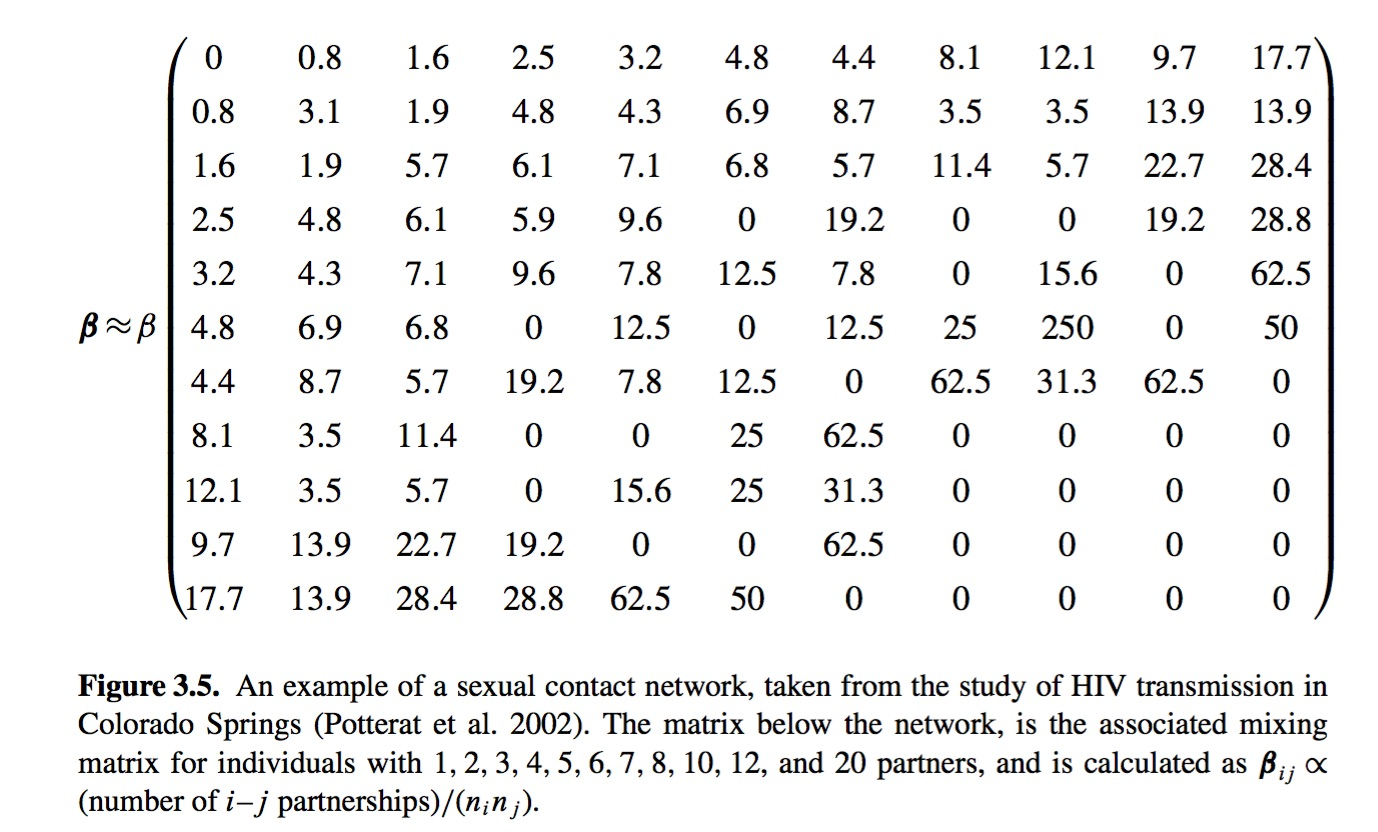

In [9]:
Image("../input/compartimentos_estruturados/HIV_ColoradoSprings_TransmissionMatrix.jpg", width = 800)

### Condição para epidemia

No caso homogêneo, analisamos (exercício) a equação $i' = \beta is - \gamma i$.

No caso com estrutura, temos infectados em mais de um grupo e isso nos leva a analisar o subsistema

$$ \begin{cases}
     \frac{\displaystyle \mathrm{d} i_H}{\displaystyle \mathrm{d}t} = \beta_{HL} \,i_L s_H + \beta_{HH} \,i_H s_H - \gamma_H \,i_H. \\
     \frac{\displaystyle \mathrm{d} i_L}{\displaystyle \mathrm{d}t} = \beta_{LL} \,i_L s_L + \beta_{LH} \,i_H s_L - \gamma_L \,i_L.
  \end{cases}
$$

Assumindo, inicialmente, que a população de suscetíveis é praticamente toda a população inicial, dentro de cada grupo, i.e. $s_L \approx n_L = N_L/N$ e $s_H \approx n_H = N_H/N$, temos 

$$ \frac{\displaystyle \mathrm{d}}{\displaystyle \mathrm{d}t} \left(\begin{matrix} i_H \\ i_L \end{matrix} \right) \lessapprox \left[ \begin{matrix} \beta_{HH}n_H - \gamma_H & \beta_{HL}n_H \\ \beta_{LH}n_L  & \beta_{LL}n_L - \gamma_L \end{matrix} \right] \left(\begin{matrix} i_H \\ i_L \end{matrix} \right).
$$

Observe que

$$ \left[ \begin{matrix} \beta_{HH}n_H - \gamma_H & \beta_{HL}n_H \\ \beta_{LH}n_L  & \beta_{LL}n_L - \gamma_L \end{matrix} \right] = B - \Gamma.
$$







### Crescimento epidêmico em cada grupo

Para que $i_H(t)$ seja crescente, vemos, da equação, que é necessário que

$$ (\beta_{HH}n_H - \gamma_H)i_H + \beta_{HL}n_H i_L > 0,
$$

enquanto que, para que $i_L(t)$ seja crescente, é necessário que

$$ (\beta_{LL}n_L - \gamma_L)i_L + \beta_{LH}n_L i_H > 0.
$$

Mas pensando em termos da interpretação de $R_0$ como o número de transmissões secundárias, podemos definir um número básico de reprodução para cada grupo:

$$ R_0^H = \frac{\beta_{HH}n_H + \beta_{LH}n_L}{\gamma_H},
$$

e

$$ R_0^L = \frac{\beta_{LL}n_L + \beta_{HL}n_H}{\gamma_L}.
$$

Mas a relação desses números básicos de reprodução com o crescimento do número de infectado em cada grupo não é imediatamente claro.

### No exemplo sintético

De qualquer maneira, considerando o exemplo sintético acima, temos

$$ R_0^H = \frac{10 \times 0.2 + 0.1 \times 0.8}{1} = 2.08 
$$

e

$$ R_0^L = \frac{1 \times 0.8 + 0.1 \times 0.2}{1} = 0.82.
$$

### Análise matricial

O fato é que o sistema está acoplado, então uma análise separada do crescimento de cada grupo de infectado não é possível. Devemos fazer uma análise conjunta.

Podemos fazer isso analisando, como dissemos antes, o sistema

$$ \frac{\displaystyle \mathrm{d}}{\displaystyle \mathrm{d}t} \left(\begin{matrix} i_H \\ i_L \end{matrix} \right) \lessapprox \left[ \begin{matrix} \beta_{HH}n_H - \gamma_H & \beta_{HL}n_H \\ \beta_{LH}n_L  & \beta_{LL}n_L - \gamma_L \end{matrix} \right] \left(\begin{matrix} i_H \\ i_L \end{matrix} \right).
$$

O crescimento inicial, ou não, de $i_H$ e/ou de $i_L$ será determinado, essencialmente, pelo maior autovalor da matriz $NB-\Gamma$ associada ao sistema acima.



### Medindo o número de infectados

O número total de infectados é $i = i_H + i_L$. 

Por outro lado, na análise do sistema acima, é mais apropriado considerarmos a norma euclidiana  $\sqrt{i_H^2 + i_L^2}$ do vetor $(i_H, i_L)$.

Como $i_H$ e $i_L$ são não-negativos, $i = i_H + i_L$ nos dá a norma da soma do vetor $(i_H, i_L)$ (ou norma $\ell^1$).

As duas medidas, felizmente, são equivalentes:

$$ \sqrt{i_H^2 + i_L^2} \leq i_H + i_L \leq \sqrt{2}\sqrt{i_H^2 + i_L^2}.
$$

De fato, basta elevar ao quadrado para obter, de um lado,

$$ i_H^2 + i_L^2 \leq i_H^2 + 2i_Hi_L + i_L^2 = (i_H + i_L)^2
$$

e, de outro, usando a desigualdade de Young $ab \leq (a^2 + b^2)/2$,

$$ (i_H + i_L)^2 = i_H^2 + 2i_Hi_L + i_L^2 \leq 2(i_H^2 + i_L^2).
$$

### Autovalores da matriz associada

Pelo susbsistema

$$ \frac{\displaystyle \mathrm{d}}{\displaystyle \mathrm{d}t} \left(\begin{matrix} i_H \\ i_L \end{matrix} \right) \lessapprox \left[ \begin{matrix} \beta_{HH}n_H - \gamma_H & \beta_{HL}n_H \\ \beta_{LH}n_L  & \beta_{LL}n_L - \gamma_L \end{matrix} \right] \left(\begin{matrix} i_H \\ i_L \end{matrix} \right).
$$

vemos que uma condição necessária para o crescimento da norma euclidiana do vetor $(i_H, i_L)$ é a de que o maior autovalor da matriz associada $NB-\Gamma$ seja positivo. 

Esta é uma matriz quadrada $2 \times 2$, portanto é fácil calcularmos os seus autovalores.

Temos

$$ \mathop{\mathrm{tr}}(NB-\Gamma) = \beta_{HH}n_H - \gamma_H + \beta_{LL}n_L - \gamma_L
$$

$$ \det(NB-\Gamma) = (\beta_{HH}n_H - \gamma_H)(\beta_{LL}n_L - \gamma_L) - \beta_{HL}n_H\beta_{LH}n_L.
$$

Em geral, o maior autovalor de uma matriz quadrada $2\times 2$ é

$$ \lambda_+ = \frac{\mathop{\mathrm{tr}}(NB-\Gamma) + \sqrt{\mathop{\mathrm{tr}}(NB-\Gamma)^2 - 4\det(NB-\Gamma)}}{2}
$$

Como 

$$ \mathop{\mathrm{tr}}(NB-\Gamma)^2 = (\beta_{HH}n_H - \gamma_H + \beta_{LL}n_L - \gamma_L)^2 = (\beta_{HH}n_H - \gamma_H )^2 + 2(\beta_{HH}n_H - \gamma_H)(\beta_{LL}n_L - \gamma_L) + (\beta_{LL}n_L - \gamma_L)^2,
$$

vemos que

$$ \mathop{\mathrm{tr}}(NB-\Gamma)^2 - 4\det(NB-\Gamma) = ((\beta_{HH}n_H - \gamma_H) - (\beta_{LL}n_L - \gamma_L))^2 + 4\beta_{HL}n_H\beta_{LL}n_L.
$$

Esperamos que $\beta_{HH}>> \beta_{LL}$, mas também que $n_L \gg n_H$, então a relação entre os dois termos do traço não é claro. De qualquer forma, vamos considerar o caso em que $\beta_{HH}n_H - \gamma_H \geq \beta_{LL}n_L - \gamma_L$.

Assumindo $\beta_{HH}n_H - \gamma_H \geq \beta_{LL}n_L - \gamma_L$, $n_L \geq n_H$ e $\beta_{LH} = \beta_{HL}$, temos

$$ \sqrt{\mathop{\mathrm{tr}}(NB-\Gamma)^2 - 4\det(NB-\Gamma)} \leq (\beta_{HH}n_H - \gamma_H) - (\beta_{LL}n_L - \gamma_L) + 2\sqrt{\beta_{HL}n_H\beta_{LH}n_L},
$$

de modo que

$$ \lambda_+ \leq \beta_{HH}n_H - \gamma_H + \sqrt{\beta_{HL}n_H\beta_{LH}n_L} \leq \beta_{HH}n_H - \gamma_H + \beta_{HL}n_L = \gamma_H \left( \frac{\beta_{HH}n_H + \beta_{HL}n_L}{\gamma_H} - 1\right).
$$

Portanto

$$ \lambda_+ \leq \gamma_H(R_0^H - 1).
$$

Se $\lambda_+ > 0$, então $R_0^H > 1$, mas essas condições não são equivalentes.

#### Maior autovalor no exemplo sintético

No exemplo, temos

$$ NB-\Gamma = \left[ \begin{matrix} 10 \times 0.2 - 1 & 0.1 \times 0.2 \\ 0.1 \times 0.8 & 1 \times 0.8 - 1 \end{matrix} \right] = \left[ \begin{matrix} 1 & 0.02 \\ 0.08 & -0.2 \end{matrix} \right],
$$

cujos autovalores são

$$ \lambda_+ \approx 1.0013, \quad \lambda_- \approx -0.2013.
$$

Observe que 

$$  \gamma_H(R_0^H - 1) \approx 1.08,
$$

o que dá uma "folga" de $1.08-1.013 = 0.0787$.

In [10]:
A = np.array([[1, 0.02], [0.08, -0.2]])
w, v = np.linalg.eig(A)
print('Autovalores:', w)
print('Autovetor do maior autovalor:', v[:,0])
print('Autovetor do menor autovalor:', v[:,1])

Autovalores: [ 1.00133186 -0.20133186]
Autovetor do maior autovalor: [0.99779005 0.06644559]
Autovetor do menor autovalor: [-0.01664588  0.99986145]


### Crescimento de cada grupo de infectados

Como a matriz associada $NB-\Gamma$ não é diagonal (a menos que não haja transmissão cruzada entre os grupos), então o **autovetor** associado ao maior autovalor tem componentes nos dois "eixos" $i_H$ e $i_L$, ou seja, ambos tem um crescimento inicial exponencial, 

$$ i_H \sim e^{\lambda_+ t}, \qquad i_L \sim e^{\lambda_+ t}
$$

A relação entre $i_H$ e $i_L$, nessa direção de maior crescimento, é dada pelas componente do autovetor associado a $\lambda_+$.

### Pontos importantes

1. O número básico de reprodução da população inteira é obtido através da análise de autovalores de uma matriz apropriada.

1. O número básico de reprodução é limitado pelos valores dos números individuais de cada grupo.

## Modelo SIR em rede de sítios

### Representação do sistema

Nesse caso, consideramos 

- $m$ **sítios**.

- Em cada sítio, uma **população total** $N_i$, com um número $S_i$ de **suscetíveis**, $I_i$ de **infectados** e $R_i$ de **recuperados**, $i=1, \ldots, m$.

- Sem vitalidade, de forma que $S_i + I_i + R_i = N_i$ é constante, para cada $i=1, \ldots, m$.

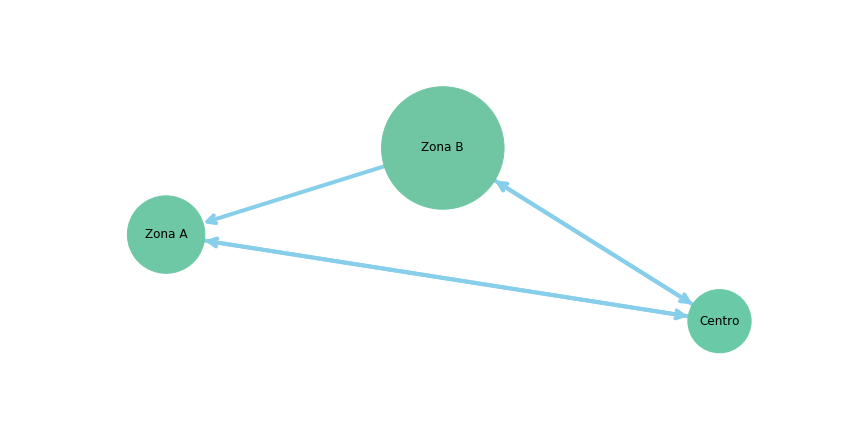

In [11]:
Image("../input/compartimentos_estruturados/rede_sitios.png", width=800)

### Dinâmica

- Denominamos por **um ciclo** cada unidade de tempo, digamos um dia.

- O **ciclo** possui uma fase **ativa**, onde a infeção pode ocorrer, e uma fase **inativa**, onde não há transmissão da infecção.

- Na fase **ativa** de cada ciclo, uma **fração** $\alpha_{ij}$ da população $N_i$ migra **do sítio $i$ para o sítio $j$**, voltando ao sítio $i$ na fase **inativa**.

- Naturalmente, $0\leq \alpha_{ij} \leq 1$, para cada $i,j=1, \ldots, m$, e $\sum_{j=1}^m\alpha_{ij} = 1$, para cada $i=1,\ldots, m$.

- Em cada sítio $j=1, \ldots, m$, os indivíduos **suscetíveis** que lá se encontram podem se tornar **infectados** ao encontrar um indivíduo infectado no mesmo sítio, com um **fator de transmissão** $\beta_j$ característico do sítio $j$ em que se encontram.

- Os indivíduos **infectados** de cada sítio, podem se recuperar com um **fator de recuperação** $\gamma_i$, característico do ambiente e dos indivíduos que habitam o sítio.

### Sistema de equações diferenciais

Temos o sistema

$$
\begin{cases}
  \displaystyle \frac{\rm d S_i}{\rm d t} = - \sum_{j=1}^m \sum_{k=1}^m \beta_j\alpha_{kj}\alpha_{ij}\frac{I_k}{\tilde N_j}S_i, & i = 1, \ldots, m, \\
  \displaystyle \frac{\rm d I_i}{\rm d t} = \sum_{j=1}^m \sum_{k=1}^m \beta_j\alpha_{kj}\alpha_{ij}\frac{I_k}{\tilde N_j}S_i - \gamma_i I_i, & i = 1, \ldots, m, \\
  \displaystyle \frac{\rm d R_i}{\rm d t} = \gamma_i I_i, & i = 1, \ldots, m,
\end{cases}
$$

onde

$$ \tilde N_j = \sum_{i=1}^n \alpha_{ij}N_i, \qquad j = 1, \ldots, m,
$$

é a população existente no sítio $j$ durante a fase ativa do ciclo.

### Conservação da população total de cada sítio

Podemos verificar, como esperado da modelagem, que a população total originária de cada sítio permanece constante:

$$ \frac{\rm d N_i}{\rm d t}  = \frac{\rm d}{\rm d t}\left( S_i + I_i + R_i \right) = 0.
$$

Assim, 

$$ N_i = S_i + I_i + R_i = \text{ constante}, \qquad \forall i =1, \ldots, m.
$$

Como consequência, também temos que a população em cada sítio durante a fase ativa do ciclo também é constante:

$$ \tilde N_j = \sum_{i=1}^n \alpha_{ij}N_i = \text{ constante}, \qquad \forall j = 1, \ldots, m.
$$

### Redução do sistema

Como no caso do modelo SIR clássico, podemos reduzir o sistema a um subsistema envolvendo apenas **suscetíveis** e **infectados**, considerando que a população total é constante.

Temos 

$$ R_i = N_i - S_i - I_i
$$

e basta consideramos

$$
\begin{cases}
  \displaystyle \frac{\rm d S_i}{\rm d t} = - \sum_{j=1}^m \sum_{k=1}^m \beta_j\alpha_{kj}\alpha_{ij}\frac{I_k}{\tilde N_j}S_i, & i = 1, \ldots, m, \\
  \displaystyle \frac{\rm d I_i}{\rm d t} = \sum_{j=1}^m \sum_{k=1}^m \beta_j\alpha_{kj}\alpha_{ij}\frac{I_k}{\tilde N_j}S_i - \gamma_i I_i, & i = 1, \ldots, m,
\end{cases}
$$

onde

$$ \tilde N_j = \sum_{i=1}^n \alpha_{ij}N_i, \qquad j=1, \ldots, m,
$$

são constantes.

### Representação vetorial

Considerando os estados na forma de vetores, 

$$ S=(S_1, \ldots, S_m), \qquad I = (I_1, \ldots, I_m),
$$

podemos escrever as equações na forma vetorial

$$
\begin{cases}
  \displaystyle \frac{\rm d S}{\rm d t} = - \rm{diag}(AI)S, \\
  \displaystyle \frac{\rm d I}{\rm d t} = \rm{diag}(AI)S - \Gamma I,
\end{cases}
$$

onde 
- $\Gamma$ é a matriz diagonal $\Gamma = \rm{diag}(\gamma_1, \ldots, \gamma_m)$, 
- $A$ é a matriz

$$ A = \left(\sum_{j=1}^m\frac{\beta_j\alpha_{kj}\alpha_{ij}}{\tilde N_j}\right)_{ik}
$$

- $\rm{diag}(AI)$ é a matriz diagonal formada pelo vetor obtido da aplicação da matriz $A$ ao vetor $I$,

$$ AI = \left(\sum_{k=1}^m\sum_{j=1}^m\frac{\beta_j\alpha_{kj}\alpha_{ij}}{\tilde N_j} I_k\right)_i
$$



## Referências

- [M. J. Keeling & P. Rohani (2007), Modeling Infectious Diseases in Humans and Animals, Princeton University Press.](https://press.princeton.edu/books/hardcover/9780691116174/modeling-infectious-diseases-in-humans-and-animals)

<!--NAVIGATOR-->

---
[<- Modelos epidemiológicos compartimentais](03.00.Aula-Modelos_compartimentais.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) | [Qualidade e comparação de modelos ->](05.00.Aula-Qualidade_e_comparacao_de_modelos.ipynb)